# Outcomes
- How to work with time-series data.
- Double and Triple expotential smoothing
- SARIMA model
- XGBoost

Approach problem based on
- Required quality
- Length of forecast period

In [2]:
#pip install statsmodels

In [3]:
#!pip install sklearn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [5]:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('currency.csv',index_col=['Time'], parse_dates=['Time'])

In [6]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2017-09-13 00:00:00 to 2017-09-21 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Ads     216 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB


In [7]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [8]:
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


Text(0, 0.5, 'No of ads watched')

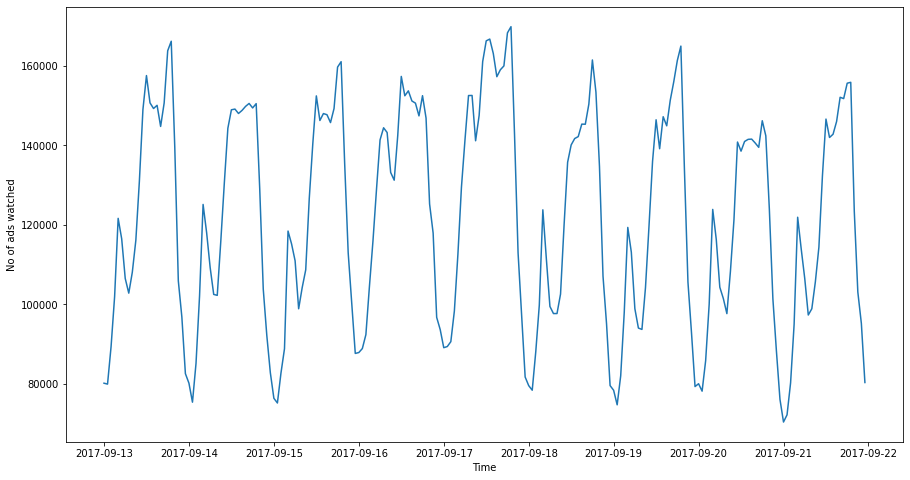

In [9]:
plt.figure(figsize=(15,8))
plt.plot(ads.Ads)
plt.xlabel('Time')
plt.ylabel('No of ads watched')

In [10]:
currency.columns

Index(['GEMS_GEMS_SPENT'], dtype='object')

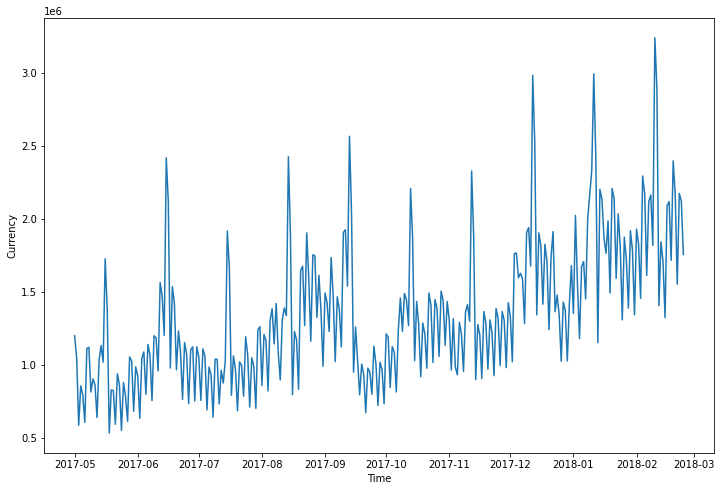

In [11]:
plt.figure(figsize=(12,8))
plt.plot(currency)
plt.xlabel('Time')
plt.ylabel('Currency')
plt.show()

In [12]:
def moving_average(series, n):
    '''
    To find the average of last n values
    '''
    return np.average(series[-n:])

In [13]:
moving_average(ads.Ads, 24)

116805.0

In [14]:
ads.Ads.rolling(window=3).sum()

Time
2017-09-13 00:00:00         NaN
2017-09-13 01:00:00         NaN
2017-09-13 02:00:00    249325.0
2017-09-13 03:00:00    271140.0
2017-09-13 04:00:00    312885.0
                         ...   
2017-09-21 19:00:00    463345.0
2017-09-21 20:00:00    434950.0
2017-09-21 21:00:00    382365.0
2017-09-21 22:00:00    321630.0
2017-09-21 23:00:00    278520.0
Name: Ads, Length: 216, dtype: float64

In [15]:
def plotMovingAverage(series, window, plot_upperlowerbound=False, scale=1.96, plot_anomalies=False):
    # Calculate the mean for a window size 
    # Skips the first n window size 
    # If window size is 3, then will start shoing values from 3rd row
    rolling_mean = series.rolling(window).mean()
    plt.figure(figsize=(12,7))
    plt.title('Moving average')
    plt.plot(rolling_mean,'g',label='Rolling Mean Trend')


    # To plot the upper and lower bound
    # The formula is from https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook#Move,-smoothe,-evaluate
    if plot_upperlowerbound:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        std_dev = np.std(series[window:]-rolling_mean[window:])
        upper_bound = rolling_mean + (mae + std_dev * scale)
        lower_bound = rolling_mean - (mae + std_dev * scale)
        plt.plot(upper_bound, 'b--', label= 'Upper Bound')
        plt.plot(lower_bound, 'c--', label = 'Lower Bound')

    # To find anomalies and plot
    if plot_anomalies:
        # Create a new empty df for anomalies same as the main df
        anomalies = pd.DataFrame(index=series.index, columns=series.columns)
        # Fill in the empty df with anomalies from lower and upper bound
        anomalies[series>upper_bound] = series[series>upper_bound]
        anomalies[series<lower_bound] = series[series<lower_bound]
        # Plot the values
        plt.plot(anomalies, 'ro', markersize=10)

    # To plot the actual values
    plt.plot(series[window:], label='Actual Values')
    plt.legend(loc='upper left')
    plt.grid(True)

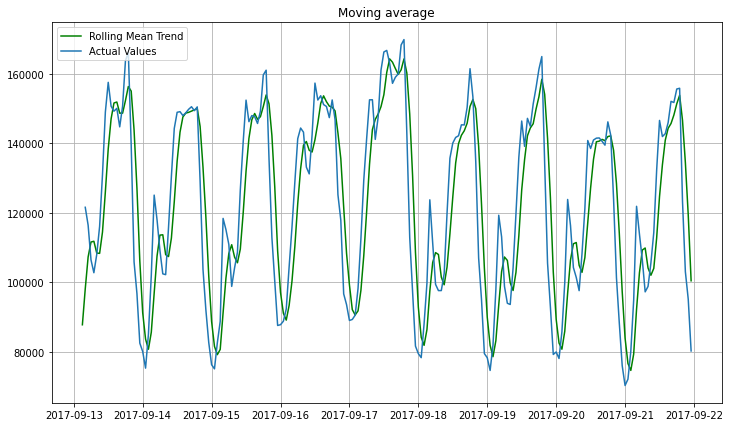

In [16]:
plotMovingAverage(ads, window=4)

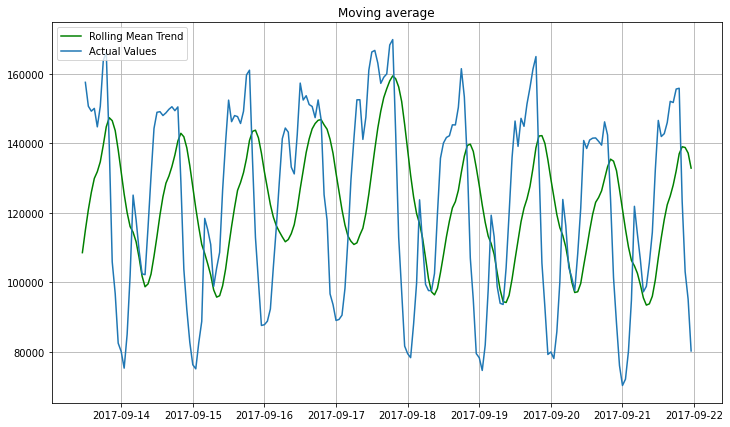

In [17]:
plotMovingAverage(ads, 12)

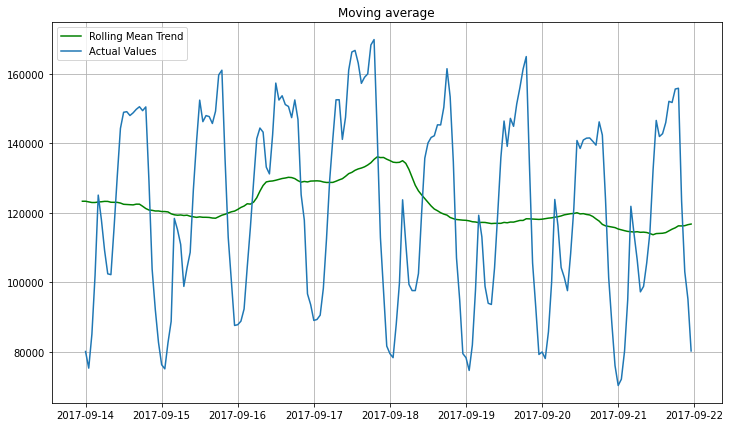

In [18]:
plotMovingAverage(ads, 24)

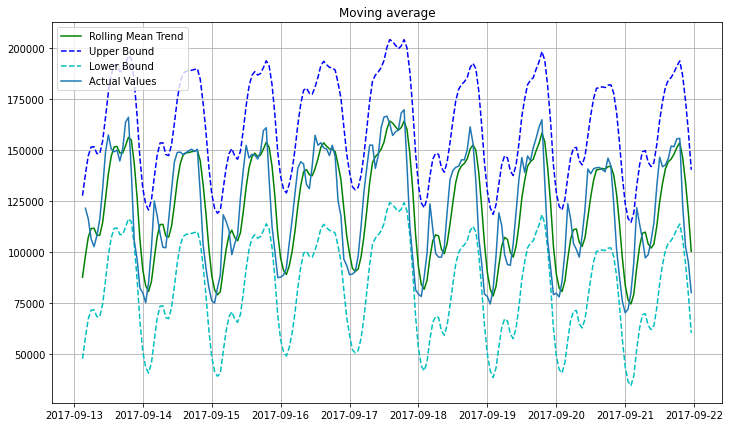

In [19]:
plotMovingAverage(ads, 4, plot_upperlowerbound=True)

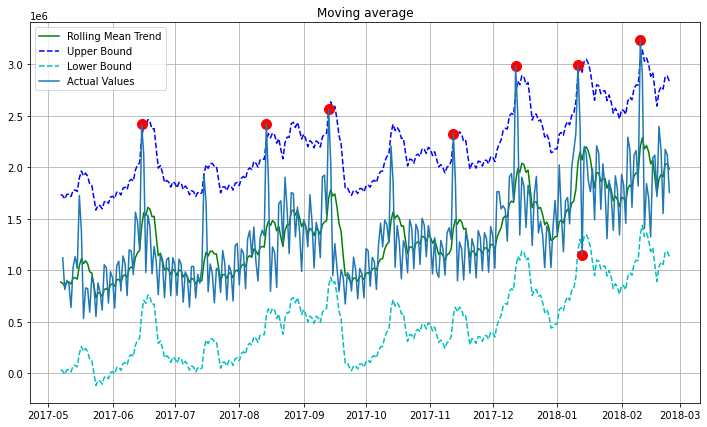

In [20]:
plotMovingAverage(currency, 7, plot_upperlowerbound=True, plot_anomalies=True)

## Expotential Smoothing

In [39]:
def expotential_smoothing(series, alpha):
    # Takes an series data
    # Alpha values - weight
    # result is a list which is used to store value at previous timestep
    result = [series[0]]
    for i in range(1, len(series)):
        result.append((alpha*series[i])+((1-alpha)*result[i-1]))
    return result

In [146]:
def plot_expotential_smoothing(series,alphas):
    # For different values of alphas
    plt.figure(figsize=(12,7))
    plt.title('Expotential Smoothing')
    for i in alphas:
        plt.plot(expotential_smoothing(series, i), label=f'Alpha={i}')
    plt.plot(series.values, label='Actual')
    plt.legend()
    plt.show()

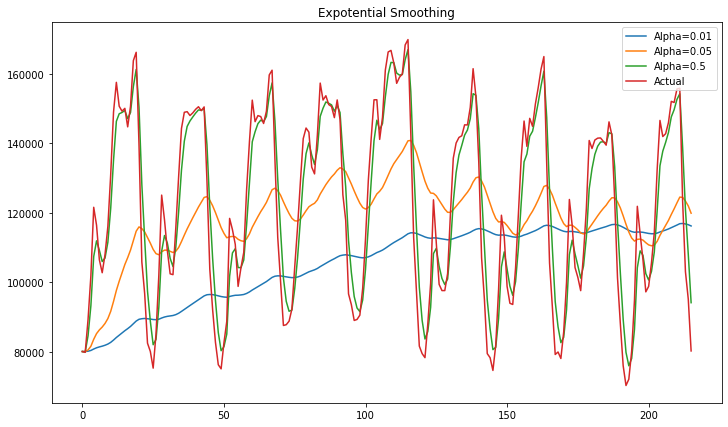

In [148]:
plot_expotential_smoothing(ads.Ads, [0.01, 0.05, 0.5])

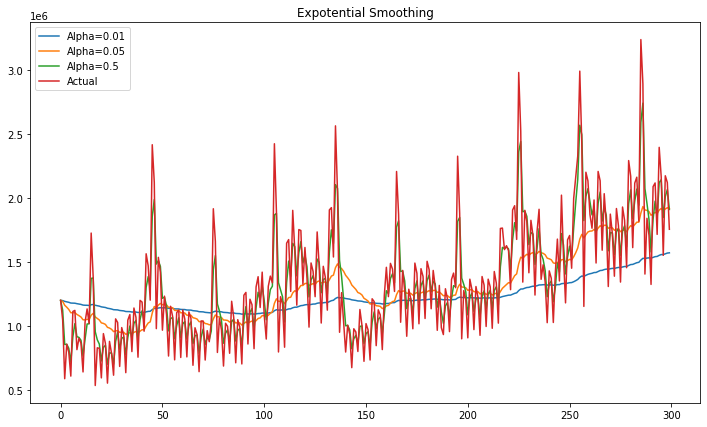

In [24]:
plot_expotential_smoothing(currency.GEMS_GEMS_SPENT, [0.01, 0.05, 0.5])

In [25]:
a = [10, 12, 11, 14, 16, 12, 14, 15, 17]

In [26]:
def double_expotential_smoothing(series, alpha, beta):
    level_average = [series[0]]
    slope_trend = [series[1]-series[0]]
    result = [series[0]]
    for i in range(len(series)-1):
        # print(f'y_x is {series[i+1]}, l_x-1 is {level_average[i]}, b_x-1 is {slope_trend[i]}')
        # print(f'Result is {(alpha*series[i+1])+((1-alpha)*(level_average[i]+slope_trend[i]))}')
        level_average.append((alpha*series[i+1])+((1-alpha)*(level_average[i]+slope_trend[i])))
        slope_trend.append((beta*(level_average[i+1]-level_average[i]))+((1-beta)*slope_trend[i]))
        result.append(level_average[i+1]+slope_trend[i+1])
    return result

In [27]:
def plot_double_expotential_smoothing(series, alphas, betas):
    plt.figure(figsize=(10,7))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_expotential_smoothing(series, alpha, beta), label=f'Alpha={alpha} & Beta={beta}')
    plt.plot(series, label='Actual Data')
    plt.legend()
    plt.grid(True)
    plt.show()

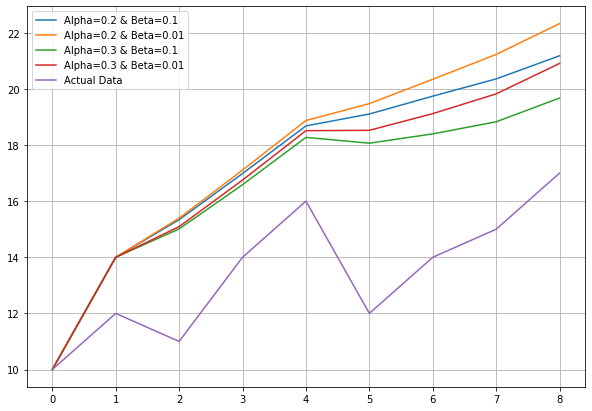

In [29]:
plot_double_expotential_smoothing(a, [0.2, 0.3], [0.1, 0.01])

# Stock Analysis

In [31]:
df = pd.read_csv(r'C:\My_Files\LambtonCollege\WIL_Term\code\fetched_data.csv')

In [33]:
df.index = df.Date

In [34]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2021-01-04,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.087082,143301900
2021-01-05,2021-01-05,128.889999,131.740005,128.429993,131.009995,129.670700,97664900
2021-01-06,2021-01-06,127.720001,131.050003,126.379997,126.599998,125.305794,155088000
2021-01-07,2021-01-07,128.360001,131.630005,127.860001,130.919998,129.581619,109578200
2021-01-08,2021-01-08,132.429993,132.630005,130.229996,132.050003,130.700089,105158200
...,...,...,...,...,...,...,...
2021-12-23,2021-12-23,175.850006,176.850006,175.270004,176.279999,175.553558,68356600
2021-12-27,2021-12-27,177.089996,180.419998,177.070007,180.330002,179.586868,74919600
2021-12-28,2021-12-28,180.160004,181.330002,178.529999,179.289993,178.551147,79144300


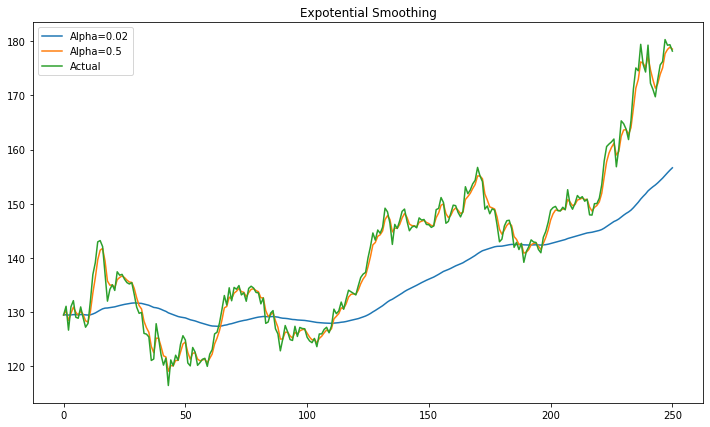

In [38]:
plot_expotential_smoothing(df.Close, [0.02, 0.5])

In [40]:
df.Open

Date
2021-01-04    133.520004
2021-01-05    128.889999
2021-01-06    127.720001
2021-01-07    128.360001
2021-01-08    132.429993
                 ...    
2021-12-23    175.850006
2021-12-27    177.089996
2021-12-28    180.160004
2021-12-29    179.330002
2021-12-30    179.470001
Name: Open, Length: 251, dtype: float64

In [47]:
df.Open.name

'Open'

In [51]:
asd = pd.DataFrame(index=df.Open.index, columns=[df.Open.name])

In [52]:
asd

,Open
Date,
2021-01-04,NaN
2021-01-05,NaN
2021-01-06,NaN
2021-01-07,NaN
2021-01-08,NaN
...,...
2021-12-23,NaN
2021-12-27,NaN
2021-12-28,NaN


In [97]:
def plotMovingAverage(series, window, plot_upperlowerbound=False, scale=1.96, plot_anomalies=False):
    # Calculate the mean for a window size 
    # Skips the first n window size 
    # If window size is 3, then will start shoing values from 3rd row
    rolling_mean = series.rolling(window).mean()
    plt.figure(figsize=(12,7))
    plt.title('Moving average')
    plt.plot(rolling_mean,'g',label='Rolling Mean Trend')


    # To plot the upper and lower bound
    # The formula is from https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook#Move,-smoothe,-evaluate
    if plot_upperlowerbound:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        std_dev = np.std(series[window:]-rolling_mean[window:])
        upper_bound = rolling_mean + (mae + std_dev * scale)
        lower_bound = rolling_mean - (mae + std_dev * scale)
        plt.plot(upper_bound, 'b--', label= 'Upper Bound')
        plt.plot(lower_bound, 'c--', label = 'Lower Bound')

    # To find anomalies and plot
    if plot_anomalies:
        # Create a new empty df for anomalies same as the main df
        anomalies = pd.DataFrame(index=series.index, columns=[series.name])
        print(series[series>upper_bound])
        print(f'---------------')
        print(series[series<lower_bound])
        # Fill in the empty df with anomalies from lower and upper bound
        anomalies[series>upper_bound] = series[series>upper_bound]
        anomalies[series<lower_bound] = series[series<lower_bound]
        # Plot the values
        plt.plot(anomalies, 'ro', markersize=10)

    # To plot the actual values
    plt.plot(series[window:], label='Actual Values')
    plt.legend(loc='upper left')
    plt.grid(True)

Date
2021-12-13    181.119995
Name: Open, dtype: float64
---------------
Series([], Name: Open, dtype: float64)


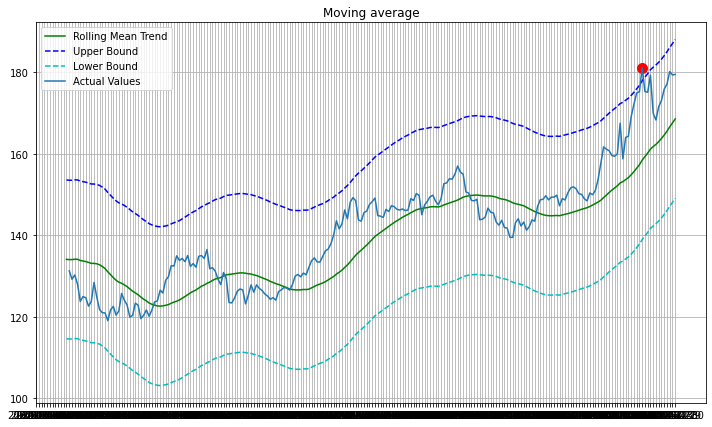

In [99]:
plotMovingAverage(df.Open, 30, plot_upperlowerbound=True, plot_anomalies=True)

In [86]:
ads.Ads[ads.Ads>90000]

Time
2017-09-13 03:00:00    101930
2017-09-13 04:00:00    121630
2017-09-13 05:00:00    116475
2017-09-13 06:00:00    106495
2017-09-13 07:00:00    102795
                        ...  
2017-09-21 18:00:00    155665
2017-09-21 19:00:00    155890
2017-09-21 20:00:00    123395
2017-09-21 21:00:00    103080
2017-09-21 22:00:00     95155
Name: Ads, Length: 181, dtype: int64

In [124]:
type(ads)

pandas.core.frame.DataFrame

In [90]:
tt

Date
2021-01-04    133.520004
2021-01-05    128.889999
2021-01-06    127.720001
2021-01-07    128.360001
2021-01-08    132.429993
                 ...    
2021-12-23    175.850006
2021-12-27    177.089996
2021-12-28    180.160004
2021-12-29    179.330002
2021-12-30    179.470001
Name: Open, Length: 251, dtype: float64

In [75]:
tt

,Open
Date,
2021-01-04,NaN
2021-01-05,NaN
2021-01-06,NaN
2021-01-07,NaN
2021-01-08,NaN
...,...
2021-12-23,NaN
2021-12-27,NaN
2021-12-28,NaN


In [62]:
aa

,Analomies
Date,
2021-01-04,NaN
2021-01-05,NaN
2021-01-06,NaN
2021-01-07,NaN
2021-01-08,NaN
...,...
2021-12-23,NaN
2021-12-27,NaN
2021-12-28,NaN


In [105]:
df.iloc[:5,:]

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2021-01-04,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.087082,143301900
2021-01-05,2021-01-05,128.889999,131.740005,128.429993,131.009995,129.670700,97664900
2021-01-06,2021-01-06,127.720001,131.050003,126.379997,126.599998,125.305794,155088000
2021-01-07,2021-01-07,128.360001,131.630005,127.860001,130.919998,129.581619,109578200
2021-01-08,2021-01-08,132.429993,132.630005,130.229996,132.050003,130.700089,105158200


In [106]:
df_1 = df.iloc[:5,:]

In [107]:
df_1

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2021-01-04,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.087082,143301900
2021-01-05,2021-01-05,128.889999,131.740005,128.429993,131.009995,129.670700,97664900
2021-01-06,2021-01-06,127.720001,131.050003,126.379997,126.599998,125.305794,155088000
2021-01-07,2021-01-07,128.360001,131.630005,127.860001,130.919998,129.581619,109578200
2021-01-08,2021-01-08,132.429993,132.630005,130.229996,132.050003,130.700089,105158200


In [108]:
df_1.Open

Date
2021-01-04    133.520004
2021-01-05    128.889999
2021-01-06    127.720001
2021-01-07    128.360001
2021-01-08    132.429993
Name: Open, dtype: float64

In [112]:
df_ana = pd.DataFrame(index=df_1.Open.index, columns=['anamoly'])

In [113]:
type(df_ana)

pandas.core.frame.DataFrame

In [114]:
df_ana

,anamoly
Date,
2021-01-04,NaN
2021-01-05,NaN
2021-01-06,NaN
2021-01-07,NaN
2021-01-08,NaN


In [116]:
df_1.Open

Date
2021-01-04    133.520004
2021-01-05    128.889999
2021-01-06    127.720001
2021-01-07    128.360001
2021-01-08    132.429993
Name: Open, dtype: float64

In [117]:
upper_bound = 132
lower_bound = 130

In [121]:
df_1.Open[df_1.Open>upper_bound]

Date
2021-01-04    133.520004
2021-01-08    132.429993
Name: Open, dtype: float64

In [123]:
df_ana[df_1.Open>upper_bound] = df_1.Open[df_1.Open>upper_bound]

ValueError: could not broadcast input array from shape (2,) into shape (2,1)

In [127]:
ads_head = ads.head(5)

In [128]:
ads_head

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [129]:
ads_anommaly = pd.DataFrame(index=ads_head.index, columns=['anomaly'])

In [130]:
ads_anommaly

,anomaly
Time,
2017-09-13 00:00:00,NaN
2017-09-13 01:00:00,NaN
2017-09-13 02:00:00,NaN
2017-09-13 03:00:00,NaN
2017-09-13 04:00:00,NaN


In [132]:
ads_head[ads_head.Ads>100000]

,Ads
Time,
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [133]:
type(ads_head.Ads)

pandas.core.series.Series

In [135]:
ads_head.Ads.to_frame()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [138]:
type(ads_head.Ads)

pandas.core.series.Series

In [137]:
type(df.Open)

pandas.core.series.Series

In [139]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2021-01-04,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.087082,143301900
2021-01-05,2021-01-05,128.889999,131.740005,128.429993,131.009995,129.670700,97664900
2021-01-06,2021-01-06,127.720001,131.050003,126.379997,126.599998,125.305794,155088000
2021-01-07,2021-01-07,128.360001,131.630005,127.860001,130.919998,129.581619,109578200
2021-01-08,2021-01-08,132.429993,132.630005,130.229996,132.050003,130.700089,105158200
...,...,...,...,...,...,...,...
2021-12-23,2021-12-23,175.850006,176.850006,175.270004,176.279999,175.553558,68356600
2021-12-27,2021-12-27,177.089996,180.419998,177.070007,180.330002,179.586868,74919600
2021-12-28,2021-12-28,180.160004,181.330002,178.529999,179.289993,178.551147,79144300


In [145]:
df['Close'].to_frame()

,Close
Date,
2021-01-04,129.410004
2021-01-05,131.009995
2021-01-06,126.599998
2021-01-07,130.919998
2021-01-08,132.050003
...,...
2021-12-23,176.279999
2021-12-27,180.330002
2021-12-28,179.289993


In [144]:
ads

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630
...,...
2017-09-21 19:00:00,155890
2017-09-21 20:00:00,123395
2017-09-21 21:00:00,103080
